In [1]:
2+2

4

In [200]:
import argparse
import copy

from matplotlib import pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import textwrap
2+2

4

# Report extraction

In [201]:
import torch
import yaml
from collections import OrderedDict
from CheXGPT.labeler.model.chexgpt_labeler import Model

HEAD_CONFIG_PATH = "./CheXGPT/configs/head/evaluation_chexgpt.yaml"
PRETRAIN_PATH = "./CheXGPT/checkpoint/model_mixed.ckpt"

with open(HEAD_CONFIG_PATH) as f:
    head_cfg = yaml.load(f, Loader=yaml.FullLoader)
label_map = head_cfg["label_map"]

# load model
model = Model(label_map).eval()
ckpt = torch.load(PRETRAIN_PATH, map_location="cpu")
new_state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    name = k[6:]  # remove `model.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict, strict=True)
tokenizer = model.get_tokenizer()


/local/scratch/a/rahman89/PycharmProjects/IDDAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model 

In [202]:


inputs = ["There is a minimal improvement in the grade of expansion of the left lung but a substantial amount of left pleural fluid persists."]
sum_prompt = ["left pleural fluid persists"]
#
position = "left"

#
# inputs = ["Atelectasis at the right lung base, possibly substantial, is new."]
#
# sum_prompt = ["Atelectasis at the right lung base"]
#
# position = "right"



def LLM(prompts):

    tokenized = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        add_special_tokens=True,
        return_tensors="pt",
        pad_to_multiple_of=8)

    with torch.inference_mode():
        outputs = model(tokenized.input_ids, tokenized.attention_mask)

    # display outputs

    detected = []
    for head_name, attrs in label_map.items():
        for attr_name, attr_info in attrs.items():
            text = outputs[head_name][attr_name]["prediction_text"]
            # print(f"{head_name} | {attr_name} | {text}")
            if text == ['exist']:
                detected.append(head_name)


    return detected


detected= LLM(inputs)

In [230]:
print(detected)

# symptoms = {"pneumonia":1}  #do(Pneumonia=1)
symptoms = {"pneumonia":0}   ##do(Pneumonia=0)



for sym in detected:
        symptoms[sym] = 1
symptoms

['effusion']


{'pneumonia': 0, 'effusion': 1}

# Inferred other labels

In [231]:
from XrayLLM.MatchLabelMechanism.LabelsMechRunNewGraph import get_genxray_labels, init_weights
from XrayLLM.MatchLabelMechanism.ControllerModels import ControllerGenerator
# from XrayLLM.MatchLabelMechanism.LabelsMechRun import get_genxray_labels, init_weights
from path_constant import project_root

parser = argparse.ArgumentParser(description='train for xray model')
parser.add_argument('--Temperature', type=float, default=1, help='Temperature')
parser.add_argument('--ANNEAL_RATE', type=float, default=0.000003, help='ANNEAL_RATE')
parser.add_argument('--temp_min', type=float, default=0.1, help='temp_min')
parser.add_argument('--num_epochs', type=int, default=200, help='num_epochs')
parser.add_argument('--cur_epochs', type=int, default=0, help='cur_epochs')
parser.add_argument('--LAMBDA_GP', type=int, default=1, help='LAMBDA_GP')
parser.add_argument('--NOISE_DIM', type=int, default=64, help='NOISE_DIM')
parser.add_argument('--sample_size', type=int, default=10000, help='sample_size')
parser.add_argument('--num_samples', type=int, default=20000, help='num_samples')
parser.add_argument('--batch_size', type=int, default=100, help='batch_size')
parser.add_argument('--SAVED_PATH', type=str, default=f'{project_root}/XrayLLM/trained_models', help='SAVED_PATH')
parser.add_argument('--label_dim', type=dict, default={}, help='label_dim')
parser.add_argument('--load_models', type=bool, default=False, help='load_models')

params, unknown = parser.parse_known_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
params.device = device

sampling_network = {
    'pneumonia': [],
    'effusion': ['pneumonia'],
    'atelectasis': ['pneumonia', 'effusion'],
    'lung opacity': ['pneumonia', 'effusion', 'atelectasis'],
}

label_names = list(sampling_network.keys())
label_dim = {lb: 2 for lb in label_names}
params.label_dim = label_dim

params.sampling_network = sampling_network

models = {}
for node in sampling_network:
    input_dim = []
    for lb in sampling_network[node]:
        input_dim.append(label_dim[lb])

    input_dim = sum(input_dim) + params.NOISE_DIM
    models[node] = ControllerGenerator(input_dim=input_dim, hid_dims=[256, 256],
                                       output_dim_list=[label_dim[node]]).to(device)

    models[node].apply(init_weights)

#### Loading the models in the same topological order.
last_model = f"{params.SAVED_PATH}/checkpoints_generators/epochLast.pth"
checkpoint = torch.load(last_model)

for id, lb in enumerate(models):
    models[lb].load_state_dict(checkpoint[f'state_dict{id}'])

sample_size = 10000




Causal Generator init: indim 64  outdim 2
Causal Generator init: indim 66  outdim 2
Causal Generator init: indim 68  outdim 2
Causal Generator init: indim 70  outdim 2


/local/scratch/a/rahman89/PycharmProjects/IDDAG/XrayLLM/MatchLabelMechanism/LabelsMechRunNewGraph.py:259: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [236]:
input_lb = {}
for lb in symptoms:
    input_lb[lb] = torch.tensor(symptoms[lb])
    input_lb[lb] = F.one_hot(input_lb[lb].to(torch.int64).to(device), num_classes=params.label_dim[lb]).float()
    # print(symptoms[lb])
    input_lb[lb] = input_lb[lb].repeat(sample_size, 1)
    print(input_lb[lb].shape)

# intv_onehot= torch.cat(list(input_lb.values()), dim=1)
generated_labels_onehot = get_genxray_labels(params, models, input_lb, sample_size)
generated_labels_onehot.shape

torch.Size([10000, 2])
torch.Size([10000, 2])


torch.Size([10000, 8])

In [237]:
from XrayLLM.MatchLabelMechanism.LabelsMechRunNewGraph import map_fill_to_discrete
from XrayLLM.MatchLabelMechanism.LabelsMechRunNewGraph import get_joint_distributions_from_samples

# from XrayLLM.MatchLabelMechanism.LabelsMechRun import map_fill_to_discrete, get_joint_distributions_from_samples

dims_list = [params.label_dim[lb] for lb in label_names]
generated_labels_full = map_fill_to_discrete(params, generated_labels_onehot, dims_list).detach().cpu().numpy().astype(
    int)
fake_dist_dict = get_joint_distributions_from_samples(params, label_names, generated_labels_full)

fake_dist_dict = dict(sorted(fake_dist_dict.items(), key=lambda item: -item[1]))

fake_dist_dict

for key in fake_dist_dict:
    fake_dist_dict[key]= (fake_dist_dict[key],0)

fake_dist_dict

{(0, 1, 0, 0): (0.4489, 0),
 (0, 1, 0, 1): (0.2361, 0),
 (0, 1, 1, 0): (0.23, 0),
 (0, 1, 1, 1): (0.085, 0),
 (0, 0, 0, 0): (1e-06, 0),
 (0, 0, 0, 1): (1e-06, 0),
 (0, 0, 1, 0): (1e-06, 0),
 (0, 0, 1, 1): (1e-06, 0),
 (1, 0, 0, 0): (1e-06, 0),
 (1, 0, 0, 1): (1e-06, 0),
 (1, 0, 1, 0): (1e-06, 0),
 (1, 0, 1, 1): (1e-06, 0),
 (1, 1, 0, 0): (1e-06, 0),
 (1, 1, 0, 1): (1e-06, 0),
 (1, 1, 1, 0): (1e-06, 0),
 (1, 1, 1, 1): (1e-06, 0)}

# Or get do(symptopm=1, Pneumonia=1) intv distribution averaged over multiple runs

In [94]:

import pickle
import numpy as np
def dict_mean(ara):
    ate_array= []
    for row in ara:
        ret = np.array(list(row.values()))
        ret= ret.reshape(1, -1)
        ate_array.append(ret)

    ate_array= np.concatenate(ate_array)
    print(ate_array.shape)

    combs= list(ara[0].keys())
    mean= np.mean(ate_array, axis=0)
    std= np.std(ate_array, axis=0)

    mean_dict= dict(zip(combs, mean))
    std_dict= dict(zip(combs, std))

    mean_dict = dict(sorted(mean_dict.items(), key=lambda item: -item[1]))

    result={}
    for iter, comb in enumerate(mean_dict):
        # print(comb, mean_dict[comb], std_dict[comb])
        result[comb]=(mean_dict[comb], std_dict[comb])
        if iter==4:
            break

    return result

path= f'{project_root}/XrayLLM/trained_models'

with open(path+ "/intv_prob.pickle", 'rb') as handle:
    b = pickle.load(handle)

if "atelectasis" in symptoms and symptoms['atelectasis']==1:
    fake_dist_dict =dict_mean(b['Atelectasis'])

if "effusion" in symptoms and symptoms['effusion']==1:
    fake_dist_dict =dict_mean(b['Pleural Effusion'])

fake_dist_dict


(200, 16)


{(1, 1, 0, 0): (0.44678799999999996, 0.014019042620664224),
 (1, 1, 0, 1): (0.25583, 0.013657536381060827),
 (1, 1, 1, 0): (0.21537150000000008, 0.010947818858110504),
 (1, 1, 1, 1): (0.0820105, 0.008433151234858771),
 (0, 0, 0, 0): (9.999999999999978e-07, 2.117582368135751e-21)}

In [238]:
symptoms

{'pneumonia': 0, 'effusion': 1}

In [239]:

# intv= torch.tensor(list(symptoms.values()))
# intv = intv.unsqueeze(0).repeat(sample_size,1)
# intv.shape


results = {}
for comb in fake_dist_dict:
    present = []
    absent = []

    if fake_dist_dict[comb][0] < 0.01:
        continue

    for iter, val in enumerate(comb):
        if val == 1:
            name = label_names[iter]
            # print(label_names[iter], symptoms.keys(), label_names[iter] in list(symptoms.keys()))
            # if label_names[iter] in list(symptoms.keys()) and symptoms[label_names[iter]]==1:
            if label_names[iter] in list(symptoms.keys()) and symptoms[label_names[iter]] == 1:
                if name!='pneumonia':  #intervening on pneumonia.
                    name = position + " " + name

            present.append(name)
        elif val == 0:
            absent.append(label_names[iter])
            
    print('Comb:', comb)
    print('present:', present)
    print('absent: ', absent)
    q1 = " and ".join(present)
    q2 = " no ".join(absent)
    q2 = "but no " + q2
    query = q1 + " " + q2
    # query= q1
    results[comb] = (fake_dist_dict[comb], query, q1)

results




Comb: (0, 1, 0, 0)
present: ['left effusion']
absent:  ['pneumonia', 'atelectasis', 'lung opacity']
Comb: (0, 1, 0, 1)
present: ['left effusion', 'lung opacity']
absent:  ['pneumonia', 'atelectasis']
Comb: (0, 1, 1, 0)
present: ['left effusion', 'atelectasis']
absent:  ['pneumonia', 'lung opacity']
Comb: (0, 1, 1, 1)
present: ['left effusion', 'atelectasis', 'lung opacity']
absent:  ['pneumonia']


{(0, 1, 0, 0): ((0.4489, 0),
  'left effusion but no pneumonia no atelectasis no lung opacity',
  'left effusion'),
 (0, 1, 0, 1): ((0.2361, 0),
  'left effusion and lung opacity but no pneumonia no atelectasis',
  'left effusion and lung opacity'),
 (0, 1, 1, 0): ((0.23, 0),
  'left effusion and atelectasis but no pneumonia no lung opacity',
  'left effusion and atelectasis'),
 (0, 1, 1, 1): ((0.085, 0),
  'left effusion and atelectasis and lung opacity but no pneumonia',
  'left effusion and atelectasis and lung opacity')}

# Generate Xray image from inferred labels

In [240]:
from diffusers.utils.torch_utils import randn_tensor
import torch
from diffusers import StableDiffusionPipeline

model_path = "./RoentGen/ckpts/roentgen"
device = 'cuda'  # or mps, cpu...

pipe = StableDiffusionPipeline.from_pretrained(model_path).to(torch.float32).to(device)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/local/scratch/a/rahman89/PycharmProjects/IDDAG/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# If same latent for all images

In [148]:

batch_size = len(inputs)
num_channels_latents = pipe.unet.config.in_channels
# 0. Default height and width to unet
height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor

shape = (batch_size, num_channels_latents, height // pipe.vae_scale_factor, width // pipe.vae_scale_factor)

latents = randn_tensor(shape, device=pipe.device, dtype=pipe.dtype)
torch.sum(latents)

tensor(-145.9082, device='cuda:0')

# Healthy

In [241]:

prompt = 'healthy'
output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4, latents=latents)
# output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)
base_img = np.array(output.images[0])

original_img = {"Healthy": ('x', base_img)}


  0%|          | 0/75 [00:00<?, ?it/s]

# Baseline

In [242]:
inputs

['There is a minimal improvement in the grade of expansion of the left lung but a substantial amount of left pleural fluid persists.']

In [243]:

prompt = inputs
output = pipe(prompt, num_inference_steps=75, height=512, width=512, guidance_scale=4, latents=latents)
base_img = np.array(output.images[0])
baseline_img = {"Baseline: \n Original Prompt": ('x', base_img)}



  0%|          | 0/75 [00:00<?, ?it/s]

In [244]:

new_results = {}

for iter, comb in enumerate(results):
    prob = results[comb][0]
    prompt = results[comb][1]
    short_prompt = results[comb][2]

    print(prompt)

    # output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)
    output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4, latents=latents)

    np_img = np.array(output.images[0])

    new_results[short_prompt] = (prob, np_img)
    if iter == 3:
        break

left effusion but no pneumonia no atelectasis no lung opacity


  0%|          | 0/75 [00:00<?, ?it/s]

left effusion and lung opacity but no pneumonia no atelectasis


  0%|          | 0/75 [00:00<?, ?it/s]

left effusion and atelectasis but no pneumonia no lung opacity


  0%|          | 0/75 [00:00<?, ?it/s]

left effusion and atelectasis and lung opacity but no pneumonia


  0%|          | 0/75 [00:00<?, ?it/s]

In [245]:
final_results = {**baseline_img, **new_results}

final_results.keys()



dict_keys(['Baseline: \n Original Prompt', 'left effusion', 'left effusion and lung opacity', 'left effusion and atelectasis', 'left effusion and atelectasis and lung opacity'])

In [246]:
import cv2
base_img = list(original_img.values())[0][1]

new_results2 = {}
for comb in final_results:
    prob, pred_img = final_results[comb]

    # compute difference
    image1 = base_img
    image2 = pred_img
    difference =  255- cv2.absdiff(image1, image2)
    #

    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)


    mm = np.random.choice([0,1], mask.shape,
              p=[.50, 0.50])
    mask = mask* mm

    dimg= copy.deepcopy(image2)
    dimg[mask==255] = [0,0,255]

    new_results2[comb] = (prob, dimg)




In [247]:
final_results = {**original_img, **final_results}


In [248]:
diff_results = {**original_img, **new_results2}
diff_results.keys()

dict_keys(['Healthy', 'Baseline: \n Original Prompt', 'left effusion', 'left effusion and lung opacity', 'left effusion and atelectasis', 'left effusion and atelectasis and lung opacity'])

In [249]:
def plot_xray(images):

    n_row = 1
    n_col = 5
    width = 4

    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * width, 4))

    # for ax in axs.ravel():
    #     ax.set_axis_off()

    plt.subplots_adjust(wspace=0, hspace=0)

    axs = axs.flatten()
    iter = 0
    for cap, ax in zip(images, axs):
        prob, img = images[cap]
        # caption = f"{cap}".capitalize()
        caption = f"{cap}".title()
        caption = textwrap.fill(caption, 17)
        if cap != "Healthy" and cap!="Baseline: \n Original Prompt":
            print(prob)
            # caption = caption + os.linesep +  f"{round(prob[0] * 100, 2)} $\pm$ {round(prob[1] * 100, 2)}%"
            caption = caption + os.linesep +  f"{round(prob[0] * 100, 2)}%"

        if iter == 0:
            sum_pr= textwrap.fill(sum_prompt[0], 19).title()
            ax.set_ylabel(f"\n{sum_pr} \n w/ N={symptoms['pneumonia']}", fontsize=22)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        iter += 1

        ax.set_title(caption, fontsize=22)
        ax.imshow(img)

    # fig.supxlabel(f"Original Prompt: {inputs}")
    # fig.supylabel(f"{inputs[0]}")

    plt.show()


(0.4489, 0)
(0.2361, 0)
(0.23, 0)


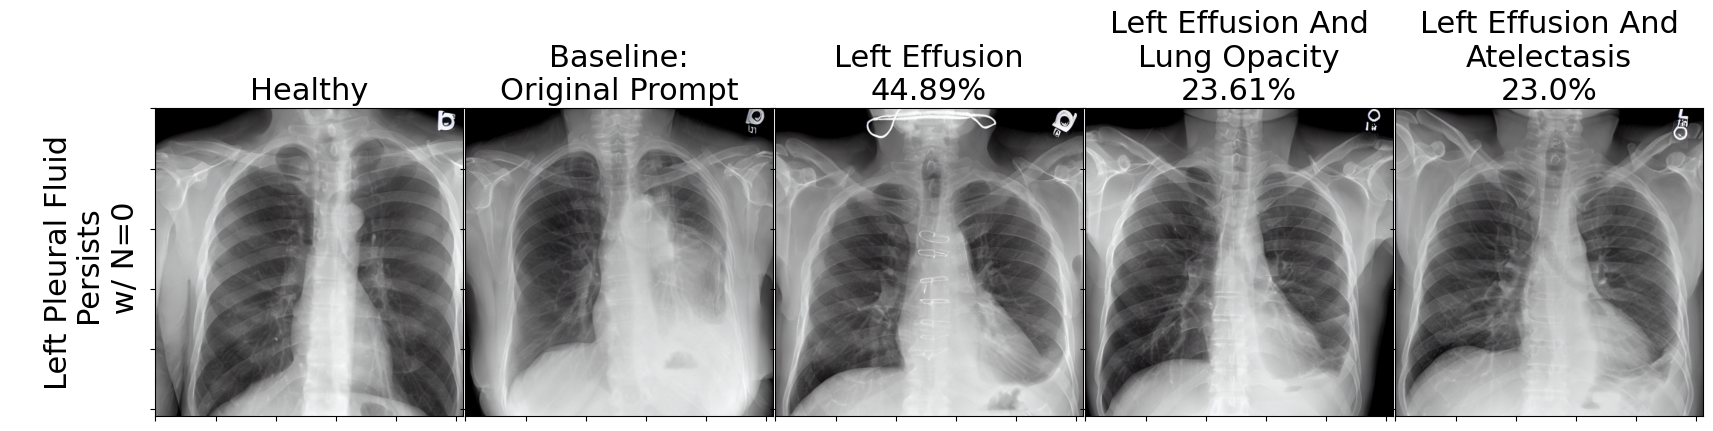

In [250]:

plot_xray(final_results)



(0.4489, 0)
(0.2361, 0)
(0.23, 0)


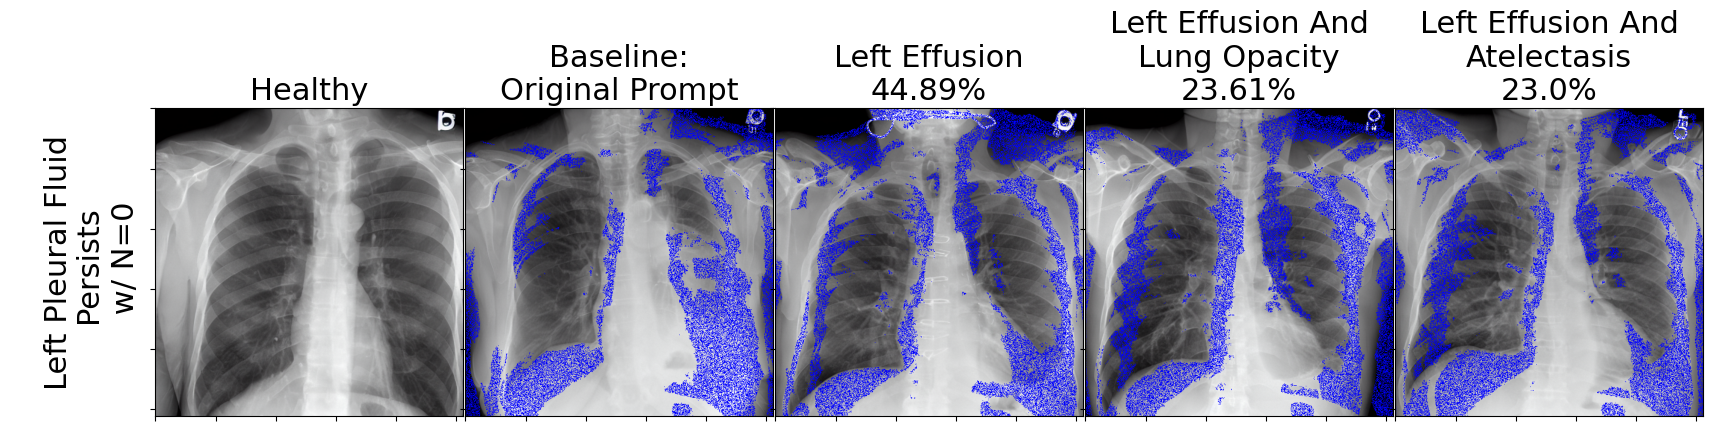

In [251]:
plot_xray(diff_results)




    # Todo:
* Are we correct according to experts?- Use a classifier.

# Print all reports

In [106]:
import pandas as pd
df =pd.read_parquet('/local/scratch/a/rahman89/PycharmProjects/IDDAG/XrayLLM/MatchLabelMechanism/train-00000-of-00005-2e64b288713e3244.parquet', engine='pyarrow')
df = df.drop('image', axis=1)

df = df[df['text'].str.contains('Pneumonia')]
df['text'].iloc[0]


for id, prompt in enumerate(df['report']):
    print(id, df['text'].iloc[id])
    print(LLM(prompt))
    print(df['report'].iloc[id])
    print("")


0 chest x-ray; 'Cardiomegaly'; 'Fracture'; 'Lung Opacity'; 'Pneumonia'
['fracture', 'lung opacity', 'widened mediastinal silhouette']
Compared to prior chest radiograph and chest CT on ___ which showed generally clear lungs and severe central adenopathy and a large goiter. Some pulmonary vascular congestion are new peribronchial opacification has developed in the right lower lobe and should be followed for potential early pneumonia Severe cardiomegaly is stable. Mediastinum is widened by adenopathy. There is no appreciable pleural effusion or pneumothorax. Left rib fractures noted.

1 chest x-ray; 'Lung Opacity'; 'Pleural Effusion'; 'Pneumonia'
['effusion', 'lung opacity', 'pneumothorax']
In comparison with the study of ___, there is increased opacification in the lower ___ of the right hemithorax in this patient with severe chronic pulmonary disease and biapical scarring. These findings could reflect volume loss in the right middle and lower lobes with pleural effusion. However, much 

KeyboardInterrupt: 

In [164]:

n_row = 1
n_col = 4

fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * width, 4))
for ax in axs.ravel():
    ax.set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)

axs = axs.flatten()
for cap, ax in zip(diff_results, axs):
    prob, img = diff_results[cap]
    caption = f"{cap}"
    if cap != "Healthy":
        caption = caption + f":{round(prob * 100, 3)}%"

    caption = textwrap.fill(caption, 28)

    ax.imshow(img)
    ax.set_title(caption)

# fig.supxlabel(f"Original Prompt: {inputs}")

plt.show()

TypeError: type str doesn't define __round__ method

Error in callback <function _draw_all_if_interactive at 0x7f423532ad40> (for post_execute):


ValueError: Image size of 204800x400 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 204800x400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 204800x400 with 4 Axes>